# Classifying Cats vs Dogs with Convolutional Neural Network on Kaggle

## GPU Settings

In [1]:
# Memory Allocation for using GPU 
import tensorflow as tf 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Pacakges

In [2]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm # nice percentage bar for tasks

# Path
BASE_PATH = os.path.abspath(".")
DATA_PATH = os.path.abspath("..\\..\\00_MLDL\\01_Projects\\02_Dogs_Cats\\")
TRAIN_DATA_PATH = os.path.join(DATA_PATH, "train\\train")
TEST_DATA_PATH = os.path.join(DATA_PATH, "test\\test")
IMG_SIZE = 50
LR = 1e-3

NAME = "Bigger0"
MODEL_NAME = f"dogsvscats-{LR}-2conv-{NAME}.model"

## Pre-processing

In [3]:
def label_image(img):
    # img word example cat.3.jpg
    # one-hot-encoding
    word_label = img.split('.')[-3]

    if word_label == "cat":
        return [1, 0]
    
    elif word_label == "dog":
        return [0, 1]


def create_train_data():
    training_data = []

    # listing in path
    for img in tqdm(os.listdir(TRAIN_DATA_PATH)):
        label = label_image(img)
        img_path = os.path.join(TRAIN_DATA_PATH, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])

    shuffle(training_data)
    np.save("train_data.npy", training_data)
    return training_data

def create_test_data():
    test_data = []

    # listing in path
    for img in tqdm(os.listdir(TEST_DATA_PATH)):
        img_path = os.path.join(TEST_DATA_PATH, img)
        img_num = img.split(".")[0]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        test_data.append([np.array(img), img_num])

    shuffle(test_data)
    np.save("test_data.npy", test_data)
    return test_data

In [5]:
train_data = create_train_data()

100%|██████████| 25000/25000 [00:17<00:00, 1422.13it/s]


In [4]:
train_data = np.load("train_data.npy", allow_pickle=True)

In [17]:
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Dense, Input, Flatten
from keras import Sequential
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.callbacks import TensorBoard
from time import time 

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=5, activation="relu", padding="same", input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=5))
model.add(Conv2D(filters=64, kernel_size=5, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=5))
model.add(Conv2D(filters=128, kernel_size=5, activation="relu", padding="same"))
#model.add(MaxPooling2D(pool_size=5))
model.add(Conv2D(filters=64, kernel_size=5, activation="relu", padding="same"))
#model.add(MaxPooling2D(pool_size=5))
model.add(Conv2D(filters=32, kernel_size=5, activation="relu", padding="same"))
#model.add(MaxPooling2D(pool_size=5))
#Bigger
model.add(Flatten())
model.add(Dense(units=1024, activation="relu"))
model.add(Dropout(0.8))
model.add(Dense(units=2, activation="softmax"))
print(model.summary())

tfboard = TensorBoard(log_dir=f"logs\\{time()}")

opt = adam(learning_rate=LR)
model.compile(
    loss="categorical_crossentropy", 
    optimizer=opt,
    metrics=["acc"])



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 50, 50, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 2, 2, 128)         204928    
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 2, 2, 64)          204864    
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 2, 2, 32)         

## Training

In [23]:
if os.path.exists(f"{MODEL_NAME}.meta"):
    model.load_weights(f"{MODEL_NAME}.meta")
    print(f"Model loaded")

train = train_data[:-500]
validation = np.array(train_data[-500:])

# Create data arrays
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = np.array([i[1] for i in train])

validation_x = np.array([i[0] for i in validation]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
validation_y = np.array([i[1] for i in validation])


Model loaded


In [20]:
history = model.fit(x=X, y=Y, validation_data=(validation_x, validation_y), batch_size= 500, epochs=10, callbacks=[
    ModelCheckpoint(f"{MODEL_NAME}.meta", monitor="val_acc", save_best_only=True, verbose=1)
] )

Train on 24500 samples, validate on 500 samples
Epoch 1/10
24500/24500 [==============================] - 5s 198us/step - loss: 0.6594 - acc: 0.5945 - val_loss: 0.6205 - val_acc: 0.6560

Epoch 00001: val_acc improved from -inf to 0.65600, saving model to dogsvscats-0.001-2conv-Bigger0.model.meta
Epoch 2/10
24500/24500 [==============================] - 4s 169us/step - loss: 0.6019 - acc: 0.6783 - val_loss: 0.5682 - val_acc: 0.7240

Epoch 00002: val_acc improved from 0.65600 to 0.72400, saving model to dogsvscats-0.001-2conv-Bigger0.model.meta
Epoch 3/10
24500/24500 [==============================] - 4s 167us/step - loss: 0.5329 - acc: 0.7384 - val_loss: 0.5375 - val_acc: 0.7440

Epoch 00003: val_acc improved from 0.72400 to 0.74400, saving model to dogsvscats-0.001-2conv-Bigger0.model.meta
Epoch 4/10
24500/24500 [==============================] - 4s 169us/step - loss: 0.4854 - acc: 0.7714 - val_loss: 0.5113 - val_acc: 0.7640

Epoch 00004: val_acc improved from 0.74400 to 0.76400, savin

In [21]:
import matplotlib.pyplot as plt

#test_data = create_test_data()
test_data = np.load("test_data.npy", allow_pickle=True)

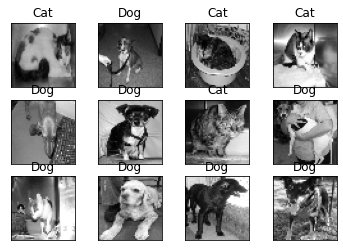

In [22]:
fig = plt.figure()

for num, data in enumerate(test_data[:12]):

    img_data = data[0]
    img_num = data[1]

    y = fig.add_subplot(3,4, num+1)
    orig = img_data
    data = img_data.reshape(1, IMG_SIZE, IMG_SIZE, 1)

    model_out = model.predict(data)[0]

    if np.argmax(model_out) == 1: str_label = "Dog"
    else: str_label = "Cat"

    y.imshow(orig, cmap="gray")
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()

    
